<p style="font-size: 10px; color: #666; text-align: right;">
Rova Ralaimidona  <a href="mailto:irova.com">irova@me.com</a>
</p>

<div style="
    background-color:rgb(210, 230, 255);
    color:rgb(0, 0, 0);
    padding: 10px;
    border-radius: 10px;
    font-weight: bold;">
<h3>Traitement des Variables temporelles</li>
</div>

# Import des librairies

In [22]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

# Chargement des données

In [23]:
# Chargement des données de data.gouv.fr, la 35ème colonne possède des Dtype mixte, l'option low_memory=False permet de contourner le problème.
# https://www.data.gouv.fr/fr/datasets/sites-references-dans-cartofriches/#/resources
# https://github.com/cnigfr/schema-friches

df_friches = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/74feb3ed-5f9f-4ef8-8fab-b0128d569a99", sep=";", low_memory=False)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches.shape[0]} friches chargées — {df_friches.shape[1]} variables")
print("Pas de doublon detectés")

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
28115 friches chargées — 50 variables
Pas de doublon detectés


# Isolation des données des friches reconverties

In [24]:
df_friches_reconv = df_friches.dropna(subset=['site_reconv_type'])
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

2612 friches chargées — 50 variables


⚠️⚠️Rova attention autre ou inconnu peut avoir une valeur métier, cette modalité peut dire 
un site a un type de reconversion malgré ce paramètre manquant, mais type inconnu et Nan apporte beaucoup de bruit -> besoin de plus de filtre ou équilibré les données avec stratification

In [25]:
# Supprimer les friches dont la reconversion est 'autre' ou 'inconnu'
for val in ['autre', 'inconnu']:
    df_friches_reconv = df_friches_reconv.drop(df_friches_reconv[df_friches_reconv['site_reconv_type'] == val].index)

# Affichez les résultats
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
print("Variable cible :")
display(df_friches_reconv['site_reconv_type'].value_counts())

2331 friches chargées — 50 variables
Variable cible :


site_reconv_type
habitat                         1100
mixte                            351
autres activités économiques     328
équipement public                215
commerce                          95
renaturation                      69
bureau                            65
aménagement d'espace public       47
industrie                         33
panneaux photovoltaiques          27
�nergie, hors photovoltaique       1
Name: count, dtype: int64

# traitement des variables temporelles

⚠️⚠️ vérifier activite_fin_annee	local_ancien_annee	local_recent_annee , mais problème beaucoup de na, remplacer par moyenne? 

In [26]:
# Suppression des variables innexploitable (taux de valeur manquante suppérieur à 90%)
empty_values = ["site_ademe_url", "site_projet_url", "site_reconv_annee", "activite_libelle", "activite_code", "bati_surface", "sol_pollution_annee", "sol_pollution_origine", "sol_pollution_commentaire", "sol_depollution_fiche", "desserte_distance", "desserte_commentaire", "geomsurf"]

df_friches_reconv = df_friches_reconv.drop(columns=empty_values)

In [27]:
# Liste des colonnes à conserver
cols_to_keep = ["site_identif_date", "site_actu_date"]

# Création d'une vraie copie ne contenant que ces deux colonnes
df_friche_temp = df_friches_reconv.drop(columns=[col for col in df_friches_reconv.columns if col not in cols_to_keep]).copy()

In [28]:
import re
from datetime import datetime
import pandas as pd

def clean_site_identif(val):
    """
    Nettoie et corrige les dates dans les identifiants de site au format AAAA-MM-JJ,
    en tenant compte des erreurs de saisie francophones (JJ-MM-AA), des formats 00xx,
    et de la contrainte que l'année ne doit pas être supérieure à 2025.

    Args:
        val (str or any): L'identifiant du site, potentiellement avec une date mal formatée.

    Returns:
        datetime.datetime or pandas.NaT: La date corrigée (objet datetime), ou pd.NaT si aucune correction n'est possible.
    """

    # 1. Gérer les valeurs manquantes ou non pertinentes
    if pd.isna(val) or str(val).strip().lower() in ['nat', 'nan', '']:
        return pd.NaT

    val = str(val).strip()

    # 2. Nettoyer la chaîne : garder uniquement les chiffres et les séparateurs de date
    val = re.sub(r'[^0-9/\-\.]', '', val)
    # Standardiser les séparateurs en tirets
    val = val.replace('/', '-').replace('.', '-')
    parts = val.split('-')

    # S'assurer qu'il y a exactement 3 parties pour une date (année, mois, jour)
    if len(parts) != 3:
        return pd.NaT

    try:
        # Convertir les parties en entiers pour les manipulations
        p1, p2, p3 = int(parts[0]), int(parts[1]), int(parts[2])
    except ValueError:
        return pd.NaT # Les parties ne sont pas des nombres valides

    # Fonction auxiliaire pour corriger les années à deux chiffres
    def _correct_two_digit_year(year_val: int) -> int:
        """
        Corrige une année à deux chiffres en une année à quatre chiffres (19xx ou 20xx).
        Applique la règle : < 35 -> 20xx, sinon 19xx.
        Si year_val est 0, elle n'est pas corrigée, permettant à la validation ultérieure d'échouer.
        """
        if year_val == 0:
            return year_val # Ne pas corriger 00, laisser la validation datetime le gérer (échouera)
        if year_val < 100:
            return 2000 + year_val if year_val <= 35 else 1900 + year_val
        return year_val

    # Fonction auxiliaire pour tenter de créer une date et valider son année
    def _try_date_and_validate(year: int, month: int, day: int) -> datetime | None:
        """
        Tente de créer un objet datetime et valide son année.
        Retourne l'objet datetime si valide et l'année est entre 1900 et 2025 (inclus), sinon None.
        """
        try:
            dt_obj = datetime(year, month, day)
            if 1900 <= dt_obj.year <= 2025: # Appliquer la contrainte d'année <= 2025
                return dt_obj
        except ValueError:
            pass
        return None

    # --- Stratégies de Parsing et Correction par ordre de priorité ---

    # Tentative 1: Format standard AAAA-MM-JJ
    # Si la première partie a 4 chiffres et ne commence PAS par '00' (pour éviter conflit avec 00JJ)
    if len(parts[0]) == 4 and not parts[0].startswith('00'):
        result = _try_date_and_validate(p1, p2, p3)
        if result:
            return result

    # Tentative 2: Formats 00JJ-MM-YY (inclut 00JJ-MM-A)
    # Ici, p1 est '00JJ', p2 est le mois, p3 est l'année (YY ou A).
    # On vérifie que la première partie commence par '00' et que la partie 'JJ' est un jour valide.
    if parts[0].startswith('00') and len(parts[0]) >= 3 and 1 <= (p1 % 100) <= 31:
        candidate_day = p1 % 100 # Le jour est les deux derniers chiffres de p1
        candidate_month = p2
        candidate_year = _correct_two_digit_year(p3) # p3 est l'année à 1, 2 ou 4 chiffres

        result = _try_date_and_validate(candidate_year, candidate_month, candidate_day)
        if result:
            return result

    # Tentative 3: YY-MM-DD (Année-Mois-Jour, où l'année est sur 1 ou 2 chiffres, ex: 01-12-31 -> 2001-12-31)
    # Cette tentative est cruciale pour le cas "outlier" 01-12-31.
    # S'applique si p1 est une année à 1 ou 2 chiffres (mais pas 00, géré par la tentative 2)
    if len(parts[0]) <= 2: # et ne commence pas par '00' car déjà géré par la tentative 2
        candidate_year = _correct_two_digit_year(p1)
        candidate_month = p2
        candidate_day = p3
        result = _try_date_and_validate(candidate_year, candidate_month, candidate_day)
        if result:
            return result

    # Tentative 4: JJ-MM-AAAA (Jour-Mois-Année, année sur 4 chiffres, ex: 01-06-2023 -> 2023-06-01)
    # Si la troisième partie a 4 chiffres, on tente de la parser comme une année
    if len(parts[2]) == 4:
        result = _try_date_and_validate(p3, p2, p1) # Inversion: p3 est l'année, p2 le mois, p1 le jour
        if result:
            return result

    # Tentative 5: JJ-MM-YY (Jour-Mois-Année, année sur 1 ou 2 chiffres, ex: 25-01-01 -> 2001-01-25)
    # Si la troisième partie a 1 ou 2 chiffres, on tente de la parser comme une année
    if len(parts[2]) <= 2:
        candidate_year = _correct_two_digit_year(p3)
        candidate_month = p2
        candidate_day = p1
        result = _try_date_and_validate(candidate_year, candidate_month, candidate_day)
        if result:
            return result

    # Tentative 6: Inversion "mal ordonné" (MM-DD-YYYY/YY écrit comme YYYY/YY-MM-DD, ex: 12-31-2000 -> 2000-12-31)
    # C'est la règle de votre code original: si p1 <= 12 (possible mois) et p3 > 31 (possible année)
    # On inverse pour essayer AAAA-MM-JJ
    if p1 <= 12 and p3 > 31:
        inverted_year = _correct_two_digit_year(p3) # p3 est l'année
        inverted_month = p1 # p1 est le mois
        inverted_day = p2 # p2 est le jour
        result = _try_date_and_validate(inverted_year, inverted_month, inverted_day)
        if result:
            return result

    # Si aucune des tentatives n'a abouti, retourner pd.NaT
    return pd.NaT

     
# Nettoyage de site_actu_date et conversion des types        
def clean_site_actu(val):
    if pd.isna(val) or not isinstance(val, str):
        return pd.NaT
    val = val.strip()

    # Cas anormal du type 0006-09-23 → on reforme une date correcte
    if val[:2] == "00":
        try:
            parts = val.split('-')
            if len(parts) != 3:
                return pd.NaT
            day = parts[0][-2:]       # ex: 0006 → 06
            month = parts[1]
           
            year = parts[2]           # ex: 23
            corrected = f"{year}-{month.zfill(2)}-{day.zfill(2)}"
            return pd.to_datetime(corrected, format="%y-%m-%d", errors="raise")
        except:
            return pd.NaT
    else:
        # cas normal en AAAA-MM-JJ
        try:
            return pd.to_datetime(val, format="%Y-%m-%d", errors="raise")
        except:
            return pd.NaT

df_friche_temp["site_identif_date_clean"] = df_friche_temp["site_identif_date"].apply(clean_site_identif)
df_friche_temp["site_identif_date_clean"]

df_friche_temp["site_actu_date_clean"] = df_friche_temp["site_actu_date"].apply(clean_site_actu)
df_friche_temp["site_actu_date_clean"]

17      2024-02-13
20      2024-03-13
25      2024-03-13
35      2024-03-13
45      2024-03-13
           ...    
28076   2024-02-13
28079   2017-11-09
28080   2024-03-13
28081   2024-03-13
28102   2018-06-27
Name: site_actu_date_clean, Length: 2331, dtype: datetime64[ns]

In [29]:
df_friche_temp["site_actu_date"].isna().sum()

np.int64(0)

In [30]:
# Séparation des composantes de date (année, mois, jour)
df_friche_temp["site_actu_annee"] = df_friche_temp["site_actu_date_clean"].dt.year
df_friche_temp["site_actu_mois"]  = df_friche_temp["site_actu_date_clean"].dt.month
df_friche_temp["site_actu_jour"]  = df_friche_temp["site_actu_date_clean"].dt.day

df_friche_temp["site_identif_annee"] = df_friche_temp["site_identif_date_clean"].dt.year
df_friche_temp["site_identif_mois"]  = df_friche_temp["site_identif_date_clean"].dt.month
df_friche_temp["site_identif_jour"]  = df_friche_temp["site_identif_date_clean"].dt.day

In [31]:
df_friche_temp

,site_identif_date,site_actu_date,site_identif_date_clean,site_actu_date_clean,site_actu_annee,site_actu_mois,site_actu_jour,site_identif_annee,site_identif_mois,site_identif_jour
17,1997-12-31,2024-02-13,1997-12-31,2024-02-13,2024,2,13,1997,12,31
20,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13
25,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13
35,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13
45,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13
...,...,...,...,...,...,...,...,...,...,...
28076,2019-12-31,2024-02-13,2019-12-31,2024-02-13,2024,2,13,2019,12,31
28079,2017-11-09,2017-11-09,2017-11-09,2017-11-09,2017,11,9,2017,11,9
28080,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13
28081,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13


In [32]:
df_friche_temp["actualisation_jour"] = (df_friche_temp["site_actu_date_clean"] - df_friche_temp["site_identif_date_clean"]
).dt.days

In [33]:
df_friche_temp["actualisation_inversée"] = df_friche_temp["actualisation_jour"] < 0

In [34]:
df_friche_temp["actualisation_inversée"].sum()

np.int64(0)

In [35]:
df_friche_temp

,site_identif_date,site_actu_date,site_identif_date_clean,site_actu_date_clean,site_actu_annee,site_actu_mois,site_actu_jour,site_identif_annee,site_identif_mois,site_identif_jour,actualisation_jour,actualisation_inversée
17,1997-12-31,2024-02-13,1997-12-31,2024-02-13,2024,2,13,1997,12,31,9540,False
20,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False
25,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False
35,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False
45,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
28076,2019-12-31,2024-02-13,2019-12-31,2024-02-13,2024,2,13,2019,12,31,1505,False
28079,2017-11-09,2017-11-09,2017-11-09,2017-11-09,2017,11,9,2017,11,9,0,False
28080,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False
28081,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False


In [36]:
import numpy as np

# Cyclisation du mois (1 à 12)
df_friche_temp["site_actu_mois_sin"] = np.sin(2 * np.pi * df_friche_temp["site_actu_mois"] / 12)
df_friche_temp["site_actu_mois_cos"] = np.cos(2 * np.pi * df_friche_temp["site_actu_mois"] / 12)

# Cyclisation du jour (1 à 31)
df_friche_temp["site_actu_jour_sin"] = np.sin(2 * np.pi * df_friche_temp["site_actu_jour"] / 31)
df_friche_temp["site_actu_jour_cos"] = np.cos(2 * np.pi * df_friche_temp["site_actu_jour"] / 31)


In [37]:
df_friche_temp.columns

Index(['site_identif_date', 'site_actu_date', 'site_identif_date_clean',
       'site_actu_date_clean', 'site_actu_annee', 'site_actu_mois',
       'site_actu_jour', 'site_identif_annee', 'site_identif_mois',
       'site_identif_jour', 'actualisation_jour', 'actualisation_inversée',
       'site_actu_mois_sin', 'site_actu_mois_cos', 'site_actu_jour_sin',
       'site_actu_jour_cos'],
      dtype='object')

In [38]:
df_friche_temp

,site_identif_date,site_actu_date,site_identif_date_clean,site_actu_date_clean,site_actu_annee,site_actu_mois,site_actu_jour,site_identif_annee,site_identif_mois,site_identif_jour,actualisation_jour,actualisation_inversée,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
17,1997-12-31,2024-02-13,1997-12-31,2024-02-13,2024,2,13,1997,12,31,9540,False,8.660254e-01,5.000000e-01,0.485302,-0.874347
20,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347
25,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347
35,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347
45,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,2019-12-31,2024-02-13,2019-12-31,2024-02-13,2024,2,13,2019,12,31,1505,False,8.660254e-01,5.000000e-01,0.485302,-0.874347
28079,2017-11-09,2017-11-09,2017-11-09,2017-11-09,2017,11,9,2017,11,9,0,False,-5.000000e-01,8.660254e-01,0.968077,-0.250653
28080,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347
28081,2024-03-13,2024-03-13,2024-03-13,2024-03-13,2024,3,13,2024,3,13,0,False,1.000000e+00,6.123234e-17,0.485302,-0.874347


In [39]:
colonnes_a_supprimer = [
    "site_identif_date",
    "site_actu_date",
    "site_identif_date_clean",
    "site_actu_date_clean",
    "actualisation_inversée",
    "site_identif_mois",
    "site_identif_jour",
    "site_actu_mois",
    "site_actu_jour"
]

df_friche_temp.drop(columns=colonnes_a_supprimer, inplace=True)

In [40]:
# en partant du principe que les modèles utilisé jusque la sont le knn et svc,

In [41]:
df_friche_temp

,site_actu_annee,site_identif_annee,actualisation_jour,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
17,2024,1997,9540,8.660254e-01,5.000000e-01,0.485302,-0.874347
20,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
25,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
35,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
45,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
...,...,...,...,...,...,...,...
28076,2024,2019,1505,8.660254e-01,5.000000e-01,0.485302,-0.874347
28079,2017,2017,0,-5.000000e-01,8.660254e-01,0.968077,-0.250653
28080,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
28081,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347


In [42]:
df_friches_silver_sanstemp = pd.read_csv("./data/friches_silver.csv", sep=",", low_memory=False, index_col= 0)

In [43]:
df_friches_silver_sanstemp

,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,longitude,latitude,...,site_type_friche_militaire,site_type_friche_portuaire,site_type_mixte,site_actu_annee,site_identif_annee,actualisation_jour,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
17,0,0,2,0,0,0,0,42877,1.337672,43.60932,...,0,0,0,2024,1997,9540,8.660254e-01,5.000000e-01,0.485302,-0.874347
20,0,0,2,0,1,1,0,143,-0.530774,49.29225,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
25,0,1,0,0,0,1,0,28389,-0.546245,49.28301,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
35,0,2,3,0,1,1,0,2619,-0.532152,49.29449,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
45,0,1,0,0,0,1,0,60709,-0.619462,49.20100,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,0,3,1,1,0,0,0,470,3.162491,46.99065,...,0,0,0,2024,2019,1505,8.660254e-01,5.000000e-01,0.485302,-0.874347
28079,0,2,6,0,1,0,0,4744834,0.803069,49.48767,...,0,0,0,2017,2017,0,-5.000000e-01,8.660254e-01,0.968077,-0.250653
28080,0,2,3,0,1,1,0,1738,-0.516165,49.26891,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347
28081,0,5,0,0,1,1,0,390,-0.511792,49.31289,...,0,0,0,2024,2024,0,1.000000e+00,6.123234e-17,0.485302,-0.874347


# Fusion et export

In [44]:
df_friche_temp = df_friche_temp.copy()  # pour éviter les copies ambiguës
df_friche_temp.index.name = df_friches_silver_sanstemp.index.name  # utile si les noms d’index doivent matcher

In [ ]:
df_merged = df_friches_silver_sanstemp.join(df_friche_temp, how="left")

df_merged

# df_merged.to_csv("./data/friches_silver.csv", index=True)

ValueError: columns overlap but no suffix specified: Index(['site_actu_annee', 'site_identif_annee', 'actualisation_jour',
       'site_actu_mois_sin', 'site_actu_mois_cos', 'site_actu_jour_sin',
       'site_actu_jour_cos'],
      dtype='object')

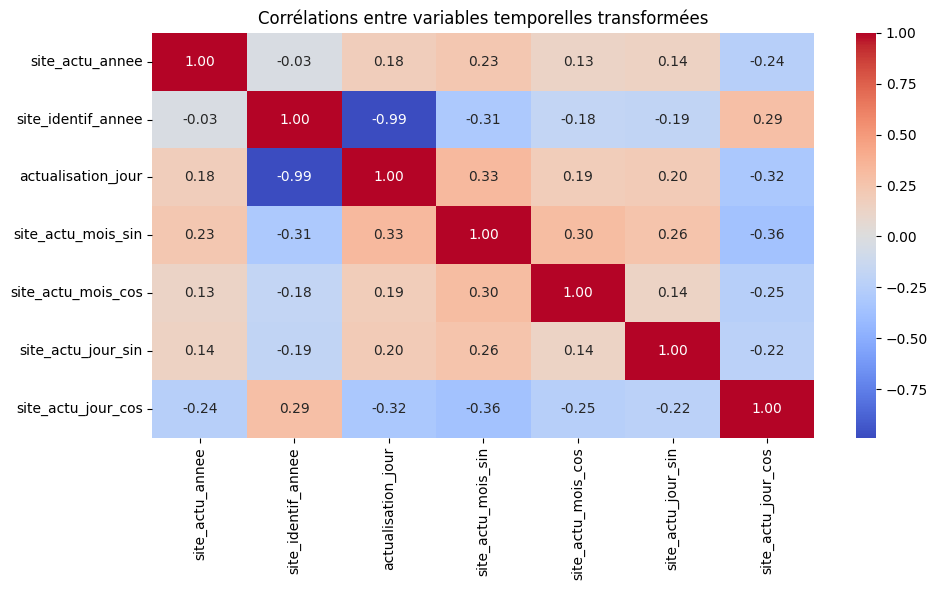

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des variables temporelles transformées
temporal_features = [
    'site_actu_annee', 'site_identif_annee', 'actualisation_jour',
    'site_actu_mois_sin', 'site_actu_mois_cos',
    'site_actu_jour_sin', 'site_actu_jour_cos'
]

# Sélection des colonnes
df_temp = df_friche_temp[temporal_features].dropna()  # on évite les NaN

# Matrice de corrélation
corr_matrix = df_temp.corr(method='pearson')

# Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélations entre variables temporelles transformées")
plt.tight_layout()
plt.show()